In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import WeibullAFTFitter, LogLogisticAFTFitter, ExponentialFitter
import seaborn as sns
import os


# Create output directory for figures if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Set visualization style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load the dataset
df = pd.read_csv('Cell1.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
display(df.head())

# Check for missing values in key columns
print("\nMissing values in key columns:")
display(df[['churn', 'months']].isnull().sum())

# Basic statistics of key variables
print("\nBasic statistics of key variables:")
display(df[['churn', 'months', 'totmrc_Mean', 'mou_Mean', 'rev_Mean', 'ovrmou_Mean']].describe())

Dataset shape: (100000, 173)


,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,rev_Range,...,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,car_buy,retdays,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,25.99,...,U,U,U,U,U,Y,New,23.0,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,153.14,...,U,U,U,U,U,Y,UNKNOWN,NaN,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,U,Y,U,U,U,Y,New,NaN,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,Y,U,U,U,U,Y,New,NaN,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,0.00,...,U,U,U,U,U,Y,New,NaN,434.0,1000005



Missing values in key columns:


churn     0
months    0
dtype: int64


Basic statistics of key variables:


,churn,months,totmrc_Mean,mou_Mean,rev_Mean,ovrmou_Mean
count,100000.000000,100000.000000,99643.000000,99643.000000,99643.000000,99643.000000
mean,0.495620,18.833990,46.179136,513.559937,58.719985,41.072247
std,0.499983,9.655794,23.623489,525.168140,46.291677,97.296150
min,0.000000,6.000000,-26.915000,0.000000,-6.167500,0.000000
25%,0.000000,11.000000,30.000000,150.750000,33.260000,0.000000
50%,0.000000,16.000000,44.990000,355.500000,48.195000,2.750000
75%,1.000000,24.000000,59.990000,703.000000,70.750000,42.000000
max,1.000000,61.000000,409.990000,12206.750000,3843.262500,4320.750000


# EDA 


Churn distribution:
churn
0    50438
1    49562
Name: count, dtype: int64
Churn rate: 49.56%


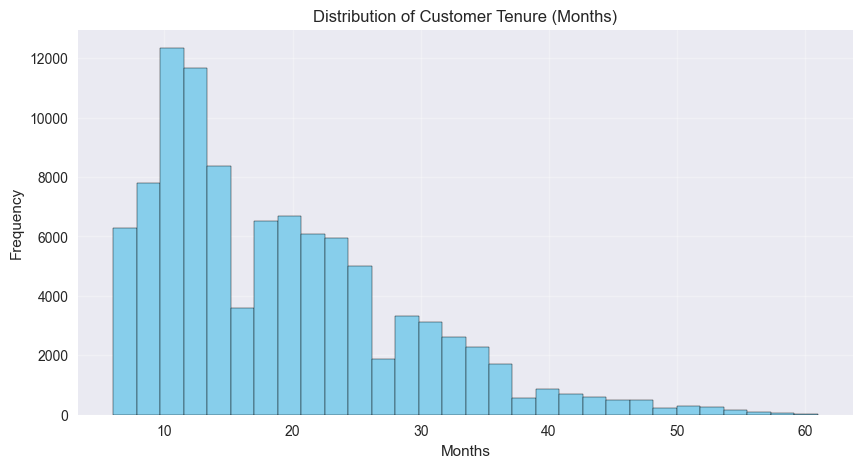

Tenure distribution plot saved to 'figures/tenure_distribution.png'


In [ ]:
# Check churn distribution
churn_counts = df['churn'].value_counts()
print(f"\nChurn distribution:\n{churn_counts}")
print(f"Churn rate: {churn_counts[1] / len(df):.2%}")

# Visualize months distribution
plt.figure(figsize=(10, 5))
plt.hist(df['months'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Customer Tenure (Months)')
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
#plt.savefig('figures/tenure_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()



In [5]:
columns = df.columns
# Print columns in a list format for better readability
print("List of columns in the DataFrame:")
column_list = list(columns)
for i, col in enumerate(column_list):
    print(f"{i+1}. {col}")

List of columns in the DataFrame:
1. rev_Mean
2. mou_Mean
3. totmrc_Mean
4. da_Mean
5. ovrmou_Mean
6. ovrrev_Mean
7. vceovr_Mean
8. datovr_Mean
9. roam_Mean
10. rev_Range
11. mou_Range
12. totmrc_Range
13. da_Range
14. ovrmou_Range
15. ovrrev_Range
16. vceovr_Range
17. datovr_Range
18. roam_Range
19. change_mou
20. change_rev
21. drop_vce_Mean
22. drop_dat_Mean
23. blck_vce_Mean
24. blck_dat_Mean
25. unan_vce_Mean
26. unan_dat_Mean
27. plcd_vce_Mean
28. plcd_dat_Mean
29. recv_vce_Mean
30. recv_sms_Mean
31. comp_vce_Mean
32. comp_dat_Mean
33. custcare_Mean
34. ccrndmou_Mean
35. cc_mou_Mean
36. inonemin_Mean
37. threeway_Mean
38. mou_cvce_Mean
39. mou_cdat_Mean
40. mou_rvce_Mean
41. owylis_vce_Mean
42. mouowylisv_Mean
43. iwylis_vce_Mean
44. mouiwylisv_Mean
45. peak_vce_Mean
46. peak_dat_Mean
47. mou_peav_Mean
48. mou_pead_Mean
49. opk_vce_Mean
50. opk_dat_Mean
51. mou_opkv_Mean
52. mou_opkd_Mean
53. drop_blk_Mean
54. attempt_Mean
55. complete_Mean
56. callfwdv_Mean
57. callwait_Mean
58.

In [6]:
# Create a function to analyze both missing values and rare categories
def analyze_columns(df):
    # Create a dataframe for missing values
    missing_df = pd.DataFrame({
        'column_name': df.columns,
        'missing_pct': (df.isnull().sum() / len(df) * 100).round(2)
    })
    
    # Function to check for rare categories (less than 5%)
    def rare_categories(col):
        if df[col].dtype == 'object' or df[col].nunique() < 20:  # Only for categorical or low-cardinality columns
            value_counts = df[col].value_counts(normalize=True) * 100
            rare_values = value_counts[value_counts < 5].index.tolist()
            if rare_values:
                return ', '.join([f"{v} ({value_counts[v]:.2f}%)" for v in rare_values])
            return "None"
        return "N/A (numeric/high-cardinality)"
    
    # Add unique values count and rare categories
    missing_df['unique_values'] = [df[col].nunique() for col in df.columns]
    missing_df['rare_categories'] = [rare_categories(col) for col in df.columns]
    
    return missing_df.sort_values('missing_pct', ascending=False)

# Call the function
column_analysis = analyze_columns(df)
display(column_analysis)

,column_name,missing_pct,unique_values,rare_categories
mailflag,mailflag,98.52,2,Y (1.29%)
solflag,solflag,98.04,2,Y (1.07%)
crtcount,crtcount,96.50,16,"3.0 (4.91%), 4.0 (1.94%), 5.0 (1.34%), 7.0 (0...."
tot_ret,tot_ret,96.02,5,"3.0 (0.73%), 4.0 (0.08%), 5.0 (0.03%)"
tot_acpt,tot_acpt,96.02,5,"2.0 (2.01%), 3.0 (0.28%), 4.0 (0.03%)"
...,...,...,...,...
avgqty,avgqty,0.00,34704,N/A (numeric/high-cardinality)
avgmou,avgmou,0.00,57931,N/A (numeric/high-cardinality)
avgrev,avgrev,0.00,14863,N/A (numeric/high-cardinality)
eqpdays,eqpdays,0.00,1555,N/A (numeric/high-cardinality)


In [7]:
# Filter to show only columns with more than 50% missing values
high_missing_columns = column_analysis[column_analysis['missing_pct'] > 50]
display(high_missing_columns)

,column_name,missing_pct,unique_values,rare_categories
mailflag,mailflag,98.52,2,Y (1.29%)
solflag,solflag,98.04,2,Y (1.07%)
crtcount,crtcount,96.50,16,"3.0 (4.91%), 4.0 (1.94%), 5.0 (1.34%), 7.0 (0...."
tot_ret,tot_ret,96.02,5,"3.0 (0.73%), 4.0 (0.08%), 5.0 (0.03%)"
tot_acpt,tot_acpt,96.02,5,"2.0 (2.01%), 3.0 (0.28%), 4.0 (0.03%)"
retdays,retdays,96.02,744,N/A (numeric/high-cardinality)
REF_QTY,REF_QTY,95.54,18,"2.0 (4.15%), 3.0 (1.21%), 4.0 (0.38%), 6.0 (0...."
wrkwoman,wrkwoman,87.49,1,None
educ1,educ1,86.48,4,4.0 (3.18%)
rmrev,rmrev,85.78,2258,N/A (numeric/high-cardinality)


# Cleaning

# Binning


In [ ]:
df['income_bin'] = pd.qcut(df['income'], q=3, labels=['Low Income', 'Mid Income', 'High Income'])
df['hnd_price_bin'] = pd.cut(df['hnd_price'],
                             bins=[0, 100, 300, df['hnd_price'].max()],
                             labels=['Budget', 'Midrange', 'Premium'])
df['eqp_age_bin'] = pd.cut(df['eqpdays'],
                           bins=[0, 365, 730, df['eqpdays'].max()],
                           labels=['<1 year', '1–2 years', '2+ years'])
df['usage_bin'] = pd.qcut(df['avg3mou'], q=4, labels=['Very Low', 'Low', 'High', 'Very High'])
df['pcowner_flag'] = df['pcowner'].apply(lambda x: 'Y' if x == 'Y' else 'N')

